Following https://avandekleut.github.io/vae/

In [4]:
import torch
import torch.nn.functional as func
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import Tuple

device = 'cuda' if torch.cuda.is_available() else 'cpu'

is_test = True

In [5]:
input_dim = 784

class Encoder(torch.nn.Module):
    def __init__(self, input_dim: Tuple[int ,int], latent_dim: int) -> None:
        super().__init__()
        hidden_dim = 512
        self.input_dim = input_dim
        # fc -> fully connected
        self.fc_1 = torch.nn.Linear(self.input_dim[0] * self.input_dim[1], hidden_dim)
        self.fc_2 = torch.nn.Linear(hidden_dim, latent_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # from x to z 
        # x.shape -> (number_of_images, image_width, image_height)
        x = torch.flatten(x, start_dim=1)
        # x.shape -> (number_of_images, image_width * image_height)
        ## now actually applying the two layers
        x_h = func.relu(self.fc_1(x))
        z = func.relu(self.fc_2(x_h))
        return z
    

class Decoder(torch.nn.Module):
    def __init__(self, latent_dim: int, output_dim: Tuple[int, int]) -> None:
        super().__init__()
        hidden_dim = 512
        self.output_dim = output_dim
        self.fc_1 = torch.nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = torch.nn.Linear(hidden_dim, self.output_dim[0] * self.output_dim[1])
    
    def forward(self, z: torch.Tensor) -> torch.Tensor:
        z_h = func.relu(self.fc_1(z))
        x_hat = torch.sigmoid(self.fc_2(z_h))
        # x_hat.shape -> (number_of_images, image_width * image_height)
        x_hat = torch.reshape(x_hat, (-1, self.output_dim[0], self.output_dim[1]))
        # x_hat.shape -> (number_of_images, image_width, image_height)
        return x_hat

class AutoEncoder(torch.nn.Module):
    def __init__(self, data_dim: Tuple[int, int], latent_dim: int) -> None:
        super().__init__()
        self.encoder = Encoder(data_dim, latent_dim)
        # in a VAE --> we add sampling here...
        self.decoder = Decoder(latent_dim, data_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

if is_test: 
    x = torch.ones((1, 28, 28))
    ae = AutoEncoder((28, 28), 144)
    ae(x)

In [7]:
def train(ae: AutoEncoder, data: torch.Tensor, nb_epochs: int):
    opt = torch.optim.Adam(ae.parameters())
    for epoch in tqdm(range(nb_epochs)):
        for x, _ in data:
            x = x.to(device) # GPU if we have one
            x_hat = ae(x)
            loss = ((x - x_hat) ** 2).sum()
            opt.zero_grad()
            loss.backward()
            opt.step()

if is_test:
    batch_size = 128
    nb_epochs = 20
    latent_dim = 2

    ae = AutoEncoder((28, 28), latent_dim)
    data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('../data',
            transform=torchvision.transforms.ToTensor(),
            download=True),
        batch_size=batch_size,
        shuffle=True
    )

    train(ae, data, nb_epochs)

100%|██████████| 20/20 [35:37<00:00, 106.88s/it]


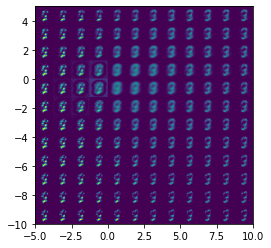

In [9]:
def plot_reconstructed(ae: AutoEncoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = ae.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

if is_test:
    plot_reconstructed(ae)

$$
\mathbb{KL}\left( \mathcal{N}(\mu, \sigma) \parallel \mathcal{N}(0, 1) \right) = \sum_{x \in X} \left( \sigma^2 + \mu^2 - \log \sigma - \frac{1}{2} \right)
$$

In [10]:

class VariableEncoder(torch.nn.Module):
    def __init__(self, input_dim: Tuple[int ,int], latent_dim: int) -> None:
        super().__init__()
        hidden_dim = 512
        self.input_dim = input_dim
        # fc -> fully connected
        self.fc_1 = torch.nn.Linear(self.input_dim[0] * self.input_dim[1], hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, latent_dim)
        self.fc_sigma = torch.nn.Linear(hidden_dim, latent_dim)

        self.gaussian = torch.distributions.Normal(0, 1)
        if device == 'cuda':
            self.gaussian.loc = self.gaussian.loc.cuda()
            self.gaussian.scale = self.gaussian.scale.cuda()

        self.aux_loss = 0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # from x to z 
        # x.shape -> (number_of_images, image_width, image_height)
        x = torch.flatten(x, start_dim=1)
        # x.shape -> (number_of_images, image_width * image_height)
        ## now actually applying the two layers
        x_h = func.relu(self.fc_1(x))
        # Variational part
        mu = self.fc_mu(x_h)
        sigma = torch.exp(self.fc_sigma(x_h))
        z = mu + sigma * self.gaussian.sample()
        self.aux_loss = (sigma ** 2 + mu ** 2 - torch.log(sigma) - 0.5).sum()
        return z